In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e11/sample_submission.csv
/kaggle/input/playground-series-s4e11/train.csv
/kaggle/input/playground-series-s4e11/test.csv


In [2]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [3]:
#filters out warnings
import os, warnings
warnings.filterwarnings("ignore")

In [4]:
train_data=pd.read_csv('/kaggle/input/playground-series-s4e11/train.csv')
test_data=pd.read_csv('/kaggle/input/playground-series-s4e11/test.csv')
submission=pd.read_csv('/kaggle/input/playground-series-s4e11/sample_submission.csv')

In [5]:
train_data.head()

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


In [6]:
train_data.shape

(140700, 20)

In [7]:
for feature in train_data: 
    print(feature, np.round(train_data[feature].isnull().mean(),4), '% missing values')

id 0.0 % missing values
Name 0.0 % missing values
Gender 0.0 % missing values
Age 0.0 % missing values
City 0.0 % missing values
Working Professional or Student 0.0 % missing values
Profession 0.2603 % missing values
Academic Pressure 0.8017 % missing values
Work Pressure 0.1984 % missing values
CGPA 0.8017 % missing values
Study Satisfaction 0.8017 % missing values
Job Satisfaction 0.1984 % missing values
Sleep Duration 0.0 % missing values
Dietary Habits 0.0 % missing values
Degree 0.0 % missing values
Have you ever had suicidal thoughts ? 0.0 % missing values
Work/Study Hours 0.0 % missing values
Financial Stress 0.0 % missing values
Family History of Mental Illness 0.0 % missing values
Depression 0.0 % missing values


Academic pressure and study satisfaction have maximum missing values as not everyone is a student 

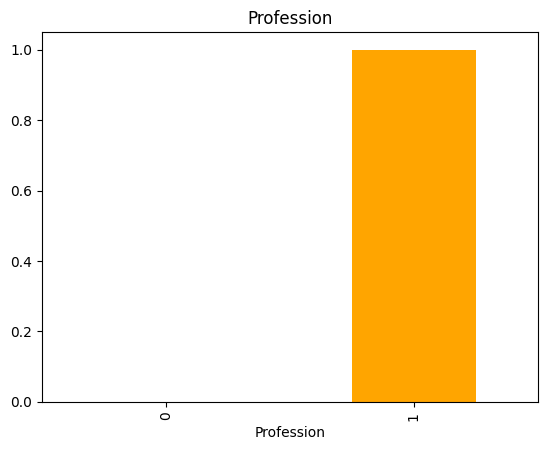

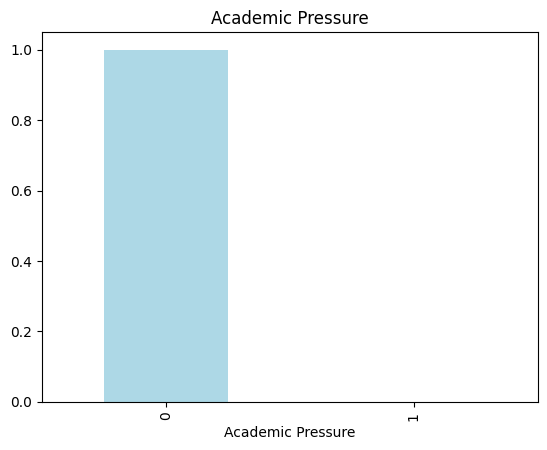

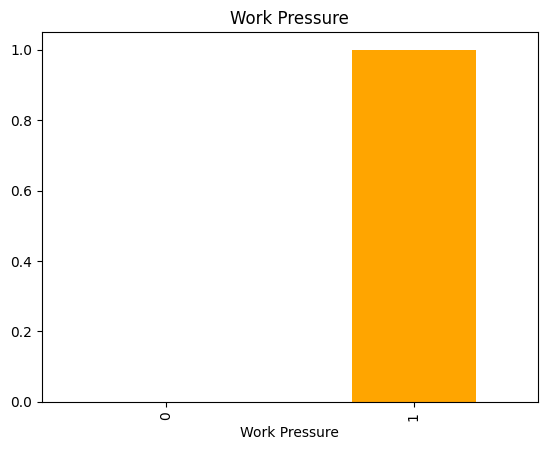

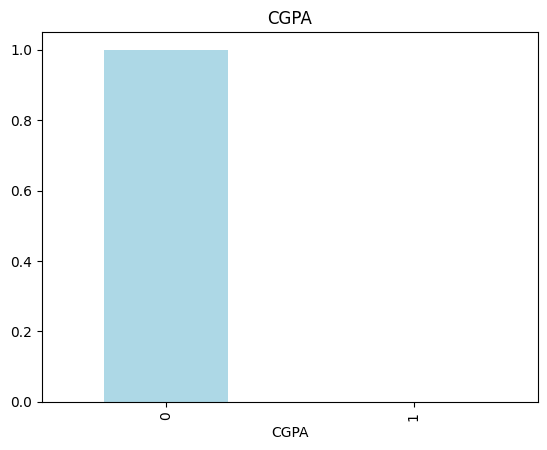

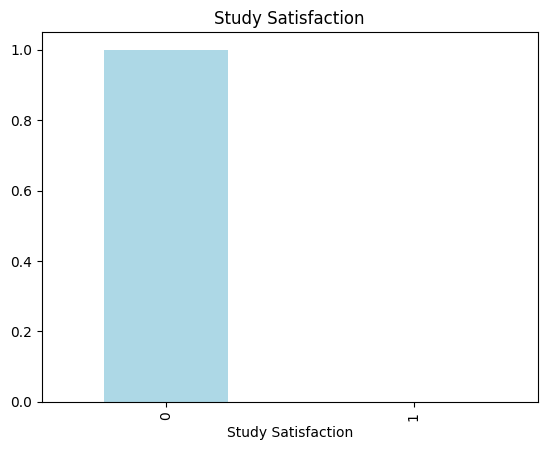

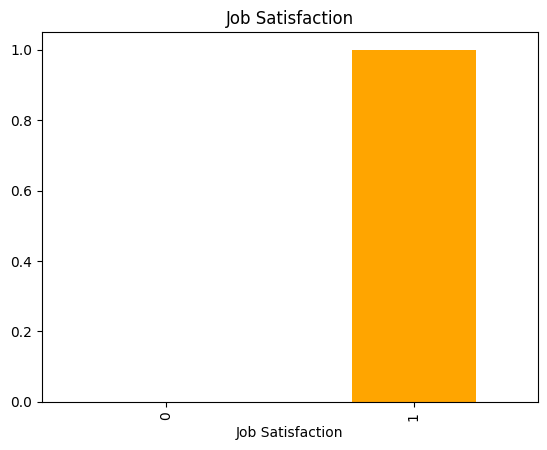

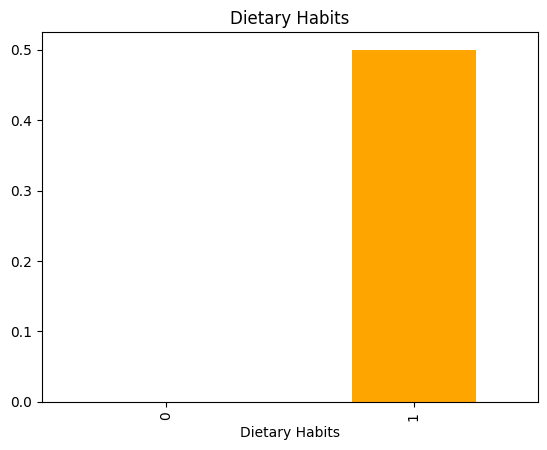

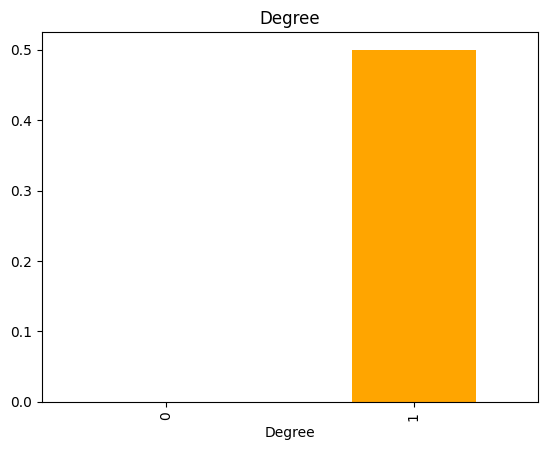

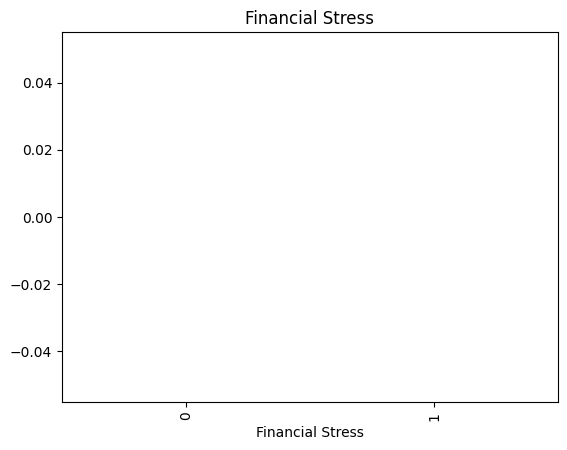

In [8]:
#trying to see if they have relation with dependent variable 
features_with_nan=[feature for feature in train_data.columns if train_data[feature].isnull().sum()>1]
for feature in features_with_nan:
    data=train_data.copy()
    
    #we are making a variable where if value is missing it  is set to 1 or it's 0 otherwise
    data[feature]=np.where(data[feature].isnull(),1,0)
    
    # let's calculate the mean of dependent variable where the information is missing or present
    data.groupby(feature)['Depression'].median().plot.bar(color=['lightblue','orange'])
    plt.title(feature)
    plt.show()

Observing values above we can notice that missing values in Academic pressure,CGPA and study satisfaction do not have significant impact on our dependent variable.

In [9]:
numerical_features=[feature for feature in train_data.columns if train_data[feature].dtype!='O']
numerical_features

['id',
 'Age',
 'Academic Pressure',
 'Work Pressure',
 'CGPA',
 'Study Satisfaction',
 'Job Satisfaction',
 'Work/Study Hours',
 'Financial Stress',
 'Depression']

In [10]:
train_data[numerical_features].head()

,id,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Work/Study Hours,Financial Stress,Depression
0,0,49.0,NaN,5.0,NaN,NaN,2.0,1.0,2.0,0
1,1,26.0,NaN,4.0,NaN,NaN,3.0,7.0,3.0,1
2,2,33.0,5.0,NaN,8.97,2.0,NaN,3.0,1.0,1
3,3,22.0,NaN,5.0,NaN,NaN,1.0,10.0,1.0,1
4,4,30.0,NaN,1.0,NaN,NaN,1.0,9.0,4.0,0


In [11]:
categorical_features=[feature for feature in train_data.columns if train_data[feature].dtype=='O']
categorical_features

['Name',
 'Gender',
 'City',
 'Working Professional or Student',
 'Profession',
 'Sleep Duration',
 'Dietary Habits',
 'Degree',
 'Have you ever had suicidal thoughts ?',
 'Family History of Mental Illness']

In [12]:
train_data[categorical_features].head()

,Name,Gender,City,Working Professional or Student,Profession,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Family History of Mental Illness
0,Aaradhya,Female,Ludhiana,Working Professional,Chef,More than 8 hours,Healthy,BHM,No,No
1,Vivan,Male,Varanasi,Working Professional,Teacher,Less than 5 hours,Unhealthy,LLB,Yes,No
2,Yuvraj,Male,Visakhapatnam,Student,NaN,5-6 hours,Healthy,B.Pharm,Yes,No
3,Yuvraj,Male,Mumbai,Working Professional,Teacher,Less than 5 hours,Moderate,BBA,Yes,Yes
4,Rhea,Female,Kanpur,Working Professional,Business Analyst,5-6 hours,Unhealthy,BBA,Yes,Yes


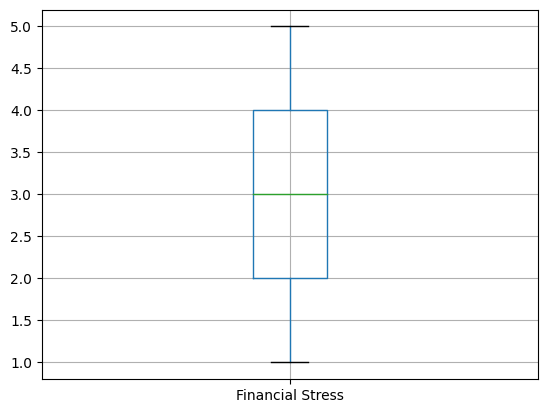

In [13]:
train_data.boxplot(column='Financial Stress')
plt.show()

# Data Preprocessing 

After checking these we can infer that 80% of them are working professional and 20% are students(based on missing values we can infer that) 
1. Name is not a necessary factor for predicting depression so we can drop it
2. CGPA,Academic Stress, Study satisfaction columns are also being dropped as they have highest missing values as not all  are students
3. Similarly Work Pressure,Job Satisfaction,Profession aren't relevant as they have missing values too as 20% are students so we drop them too.
4. Degree and Dietary habits have missing values too but they have impact and they are categorical so we fill in with mode
5. Financial stress has missing values too, we will use mean as from box plot we don't see any outliers that will affect the mean


In [14]:
y=train_data['Depression']
train_data.drop(['Depression'], inplace=True,axis=1)

In [15]:
train_len=len(train_data) #we are preprocessing both train and test data so we combine it 
data=pd.concat([train_data,test_data],axis=0).reset_index()
data

,index,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness
0,0,0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No
1,1,1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No
2,2,2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No
3,3,3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes
4,4,4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234495,93795,234495,Zoya,Female,49.0,Jaipur,Working Professional,Pilot,NaN,3.0,NaN,NaN,5.0,Less than 5 hours,Moderate,BSc,Yes,2.0,2.0,Yes
234496,93796,234496,Shlok,Male,29.0,Ahmedabad,Working Professional,Pilot,NaN,5.0,NaN,NaN,1.0,7-8 hours,Moderate,BE,Yes,11.0,3.0,Yes
234497,93797,234497,Rishi,Male,24.0,Visakhapatnam,Student,NaN,1.0,NaN,7.51,4.0,NaN,7-8 hours,Moderate,B.Tech,No,7.0,1.0,No
234498,93798,234498,Eshita,Female,23.0,Kalyan,Working Professional,Marketing Manager,NaN,4.0,NaN,NaN,2.0,5-6 hours,Healthy,BA,Yes,7.0,5.0,Yes


In [16]:
#lets start by dropping columns we mentioned above
data.drop(['id','index','Name','Profession','Academic Pressure','Work Pressure','CGPA','Study Satisfaction','Job Satisfaction'],axis=1,inplace=True)
#filling in missing categories with mode
data['Dietary Habits']=data['Dietary Habits'].fillna(data['Dietary Habits'].mode())
data['Degree']=data['Degree'].fillna(data['Degree'].mode())

#filling in numerical missing values with mean
data['Financial Stress']=data['Financial Stress'].fillna(data['Financial Stress'].mean())


In [17]:
#Understanding sleep duration column
data['Sleep Duration'].value_counts()

Sleep Duration
Less than 5 hours                      64445
7-8 hours                              61460
More than 8 hours                      54916
5-6 hours                              53546
6-7 hours                                 15
3-4 hours                                 15
4-5 hours                                 13
2-3 hours                                  9
8-9 hours                                  8
4-6 hours                                  7
1-6 hours                                  6
No                                         4
6-8 hours                                  4
9-5                                        3
9-11 hours                                 3
1-2 hours                                  3
Unhealthy                                  3
9-5 hours                                  3
Sleep_Duration                             2
Meerut                                     2
3-6 hours                                  2
than 5 hours                            

Here as observed there are some values which seems to be miss placed and not belonging so those we can set to null
Then there are some typing mistakes. We will map those values below

In [18]:
sleep_duration_mapping={
    'Less than 5 hours': 4,
    '7-8 hours': 7.5,
    'More than 8 hours':9,
    '5-6 hours': 5.5,
    '6-7 hours': 6.5,
    '3-4 hours': 3.5,
    '4-5 hours': 4.5,
    '2-3 hours': 2.5,
    '8-9 hours': 8.5,
    '4-6 hours': 5,
    '1-6 hours': 3.5,
    'No': np.nan,
    '6-8 hours': 7,
    '9-5': 7,
    '9-11 hours': 10,
    '1-2 hours': 1.5,
    'Unhealthy': np.nan,
    '9-5 hours': 7,
    'Sleep_Duration': np.nan,
    'Meerut': np.nan,
    '3-6 hours': 4.5,
    'than 5 hours':4,
    '10-6 hours': 8,
    '1-3 hours': 2,  
    '9-6 hours':  7.5,
    '10-11 hours': 10.5,                               
    '8-89 hours' : 48.5,                              
    'Have_you_ever_had_suicidal_thoughts': np.nan,
    'Vivan': np.nan,                                      
    '20-21 hours':20.5,
    '60-65 hours': 62.5,                                
    '6 hours':  6,                                  
    '50-75 hours':62.5,                                                                      
    '35-36 hours':  35.5,                              
    'Pune': np.nan,                                     
    '45-48 hours': 46.5,                              
    'Work_Study_Hours':np.nan,                          
    '49 hours': 49,                                  
    '8 hours': 8,                                 
    'Indore': np.nan,                                
    '55-66 hours': 60.5,
    'Moderate': np.nan,                                   
    '40-45 hours': 42.5,                               
    '9-10 hours':9.5,
    '0': 0,
    '45': 45
}

In [19]:
data['Sleep Duration']=data['Sleep Duration'].replace(sleep_duration_mapping)
print(data['Sleep Duration'].isnull().sum())
data['Sleep Duration'].value_counts()

17


Sleep Duration
4.0     64447
7.5     61462
9.0     54916
5.5     53546
3.5        21
6.5        15
4.5        15
7.0        10
2.5         9
8.5         8
5.0         7
8.0         3
10.0        3
1.5         3
10.5        2
2.0         2
45.0        2
62.5        2
0.0         1
6.0         1
20.5        1
48.5        1
60.5        1
46.5        1
49.0        1
35.5        1
42.5        1
9.5         1
Name: count, dtype: int64

In [20]:
data['Sleep Duration']=data['Sleep Duration'].fillna(data['Sleep Duration'].mean())

In [21]:
#encoding cateogrical variables
new_categorical_features=['Gender','City','Working Professional or Student','Dietary Habits','Degree','Have you ever had suicidal thoughts ?','Family History of Mental Illness']
le=LabelEncoder()
for feature in new_categorical_features:
    data[feature]=le.fit_transform(data[feature])

In [22]:
data.head()

,Gender,Age,City,Working Professional or Student,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness
0,0,49.0,62,1,9.0,11,50,0,1.0,2.0,0
1,1,26.0,118,1,4.0,32,92,1,7.0,3.0,0
2,1,33.0,123,0,5.5,11,34,1,3.0,1.0,0
3,1,22.0,79,1,4.0,22,44,1,10.0,1.0,1
4,0,30.0,46,1,5.5,32,44,1,9.0,4.0,1


After preprocessing we split dataset again

In [23]:
train=data[:train_len]
test=data[train_len:]

In [24]:
#we split train data into training set and validation set
from sklearn.model_selection import train_test_split
X_train, X_val,y_train, y_val=train_test_split(train, y, test_size=0.2,random_state=42)


# Model Training

In [25]:
def classify(model):
    model.fit(X_train,y_train)
    print("Accuracy:",model.score(X_train,y_train))
    score=cross_val_score(model,train,y,cv=5)
    print("CV score",np.mean(score))

In [26]:
classify(LogisticRegression())

Accuracy: 0.9228056147832268
CV score 0.9225230987917555


In [27]:
classify(XGBClassifier())

Accuracy: 0.9358742004264392
CV score 0.9226439232409381


In [28]:
classify(LGBMClassifier(verbose=0))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Accuracy: 0.9278518123667377
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
CV score 0.924136460554371


In [29]:
classify(CatBoostClassifier(verbose=0))

Accuracy: 0.9333866382373845
CV score 0.9238877043354655


XGBoost give highest accuracy 

In [30]:
model=CatBoostClassifier(verbose=0)
classify(model)

Accuracy: 0.9333866382373845
CV score 0.9238877043354655


# Submission

In [31]:
pred=model.predict(test)
pred

array([0, 0, 0, ..., 0, 1, 0])

In [32]:
submission["Depression"]=pred
submission

,id,Depression
0,140700,0
1,140701,0
2,140702,0
3,140703,1
4,140704,0
...,...,...
93795,234495,0
93796,234496,1
93797,234497,0
93798,234498,1


In [33]:
submission.to_csv("submission.csv",index=False)